In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import random

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
print("Loading dataset...")
dataset_path = './data/physionet_39_features_and_target_no_leakage.csv'
df = pd.read_csv(dataset_path)

Loading dataset...


In [5]:
target_var = 're.admission.within.6.months'
feature_cols = [col for col in df.columns if col != target_var]


In [6]:
X = df[feature_cols].values
y = df[target_var].values

print(f"Dataset loaded with {X.shape[0]} samples and {X.shape[1]} features")
print(f"Target: {target_var}")

Dataset loaded with 2008 samples and 39 features
Target: re.admission.within.6.months


In [7]:
X = df[feature_cols].values
y = df[target_var].values

print(f"Dataset loaded with {X.shape[0]} samples and {X.shape[1]} features")
print(f"Target: {target_var}")

Dataset loaded with 2008 samples and 39 features
Target: re.admission.within.6.months


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
mask_train = ~np.isnan(X_train)
mask_test = ~np.isnan(X_test)

In [10]:
def preprocess_with_knn(X_missing, k=5):
    """Preimpute missing values using KNN imputer."""
    imputer = KNNImputer(n_neighbors=k)
    X_imputed = imputer.fit_transform(X_missing)
    return X_imputed

In [11]:
print("Performing initial KNN imputation...")
X_train_knn_imputed = preprocess_with_knn(X_train)
X_test_knn_imputed = preprocess_with_knn(X_test)


Performing initial KNN imputation...


In [12]:
scaler = StandardScaler()
X_train_knn_scaled = scaler.fit_transform(X_train_knn_imputed)
X_test_knn_scaled = scaler.transform(X_test_knn_imputed)

In [13]:
class ImprovedNAA(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_norm=True):
        """
        Improved Neighborhood Aware Autoencoder (I-NAA) as described in the paper.
        
        Parameters:
        - input_dim: Number of features in the dataset
        - hidden_dim: Size of the hidden layer (undercomplete as per the paper)
        - batch_norm: Whether to use batch normalization
        """
        super(ImprovedNAA, self).__init__()
        
        # Encoder
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_dim, hidden_dim))
        if batch_norm:
            encoder_layers.append(nn.BatchNorm1d(hidden_dim))
        encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder
        decoder_layers = []
        decoder_layers.append(nn.Linear(hidden_dim, input_dim))
        if batch_norm:
            decoder_layers.append(nn.BatchNorm1d(input_dim))
        decoder_layers.append(nn.ReLU())
        self.decoder = nn.Sequential(*decoder_layers)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='none')
    
    def forward(self, output, target, mask):
        """
        Custom loss function that only considers observed values in the loss calculation.
        
        Parameters:
        - output: Model output
        - target: True values
        - mask: Binary mask where 1 indicates observed values and 0 indicates missing values
        """
        mse_loss = self.mse(output, target)
        masked_loss = mse_loss * mask
        return masked_loss.sum() / mask.sum()

In [15]:
batch_size = 64
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_knn_scaled),
    torch.FloatTensor(X_train_knn_scaled),  # Target is the same as input for autoencoder
    torch.FloatTensor(mask_train)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [16]:
val_dataset = TensorDataset(
    torch.FloatTensor(X_test_knn_scaled),
    torch.FloatTensor(X_test_knn_scaled),  # Target is the same as input for autoencoder
    torch.FloatTensor(mask_test)
)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [17]:
input_dim = X_train.shape[1]
hidden_dim = input_dim // 2  # Undercomplete architecture as per paper
learning_rate = 0.001
num_epochs = 100
reapply_knn_every = 10  # Re-apply KNN every 10 epochs
k_bounds = (3, 10)  # Range of k values for KNN

model = ImprovedNAA(input_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = CustomLoss()

In [18]:
def train_inaa(model, train_loader, val_loader, optimizer, criterion, num_epochs=100,
              reapply_knn_every=10, k_bounds=(3, 10), device=device):
    """
    Train the I-NAA model with the improvements described in the paper:
    - Re-apply KNN imputation every N epochs with different k values
    - Change the values to be imputed at each epoch
    """
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    # Get original data for re-imputation
    X_train_np = X_train.copy()  # Original training data with missing values
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        # Re-apply KNN imputation with a different k value every N epochs
        if epoch % reapply_knn_every == 0:
            # Choose a random k value within the bounds
            k = np.random.randint(k_bounds[0], k_bounds[1] + 1)
            print(f"Epoch {epoch}: Re-applying KNN imputation with k={k}")
            
            X_train_reimputed = preprocess_with_knn(X_train_np, k=k)
            X_train_reimputed_scaled = scaler.transform(X_train_reimputed)
            
            # Update the dataloader with re-imputed data
            train_dataset = TensorDataset(
                torch.FloatTensor(X_train_reimputed_scaled),
                torch.FloatTensor(X_train_reimputed_scaled),
                torch.FloatTensor(mask_train)
            )
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Training loop
        for batch_idx, (data, target, mask) in enumerate(train_loader):
            data, target, mask = data.to(device), target.to(device), mask.to(device)
            
            # Introduce random missingness for this epoch to change imputation locations
            if epoch > 0:  # Skip for the first epoch to start with the original missingness
                random_mask = torch.rand_like(mask) < 0.1  # 10% random new missingness
                data_with_new_missingness = data.clone()
                # Only apply to observed values (mask==1)
                data_with_new_missingness[random_mask & (mask == 1)] = 0
                # Update mask to reflect new missingness
                new_mask = mask.clone()
                new_mask[random_mask & (mask == 1)] = 0
            else:
                data_with_new_missingness = data
                new_mask = mask
            
            # Forward pass
            optimizer.zero_grad()
            output = model(data_with_new_missingness)
            
            # Calculate loss
            loss = criterion(output, target, new_mask)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_data, val_target, val_mask in val_loader:
                val_data, val_target, val_mask = val_data.to(device), val_target.to(device), val_mask.to(device)
                val_output = model(val_data)
                val_loss += criterion(val_output, val_target, val_mask).item()
        
        # Average loss
        train_loss = epoch_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_inaa_model.pt')
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    # Load the best model
    model.load_state_dict(torch.load('best_inaa_model.pt'))
    
    return model, train_losses, val_losses


In [19]:
print("\nTraining I-NAA model...")
model, train_losses, val_losses = train_inaa(
    model, train_loader, val_loader, optimizer, criterion, num_epochs,
    reapply_knn_every, k_bounds, device
)


Training I-NAA model...
Epoch 0: Re-applying KNN imputation with k=9
Epoch 1/100, Train Loss: 1.355339, Val Loss: 1.016506
Epoch 2/100, Train Loss: 1.150547, Val Loss: 0.962690
Epoch 3/100, Train Loss: 1.004942, Val Loss: 0.843850
Epoch 4/100, Train Loss: 0.878620, Val Loss: 0.762293
Epoch 5/100, Train Loss: 0.838452, Val Loss: 0.706094
Epoch 6/100, Train Loss: 0.781489, Val Loss: 0.663670
Epoch 7/100, Train Loss: 0.752880, Val Loss: 0.630861
Epoch 8/100, Train Loss: 0.735674, Val Loss: 0.605295
Epoch 9/100, Train Loss: 0.804387, Val Loss: 0.593916
Epoch 10/100, Train Loss: 0.685439, Val Loss: 0.568082
Epoch 10: Re-applying KNN imputation with k=6
Epoch 11/100, Train Loss: 0.729547, Val Loss: 0.548607
Epoch 12/100, Train Loss: 0.649241, Val Loss: 0.536124
Epoch 13/100, Train Loss: 0.664379, Val Loss: 0.534251
Epoch 14/100, Train Loss: 0.690820, Val Loss: 0.518664
Epoch 15/100, Train Loss: 0.643243, Val Loss: 0.504826
Epoch 16/100, Train Loss: 0.625011, Val Loss: 0.494128
Epoch 17/100,

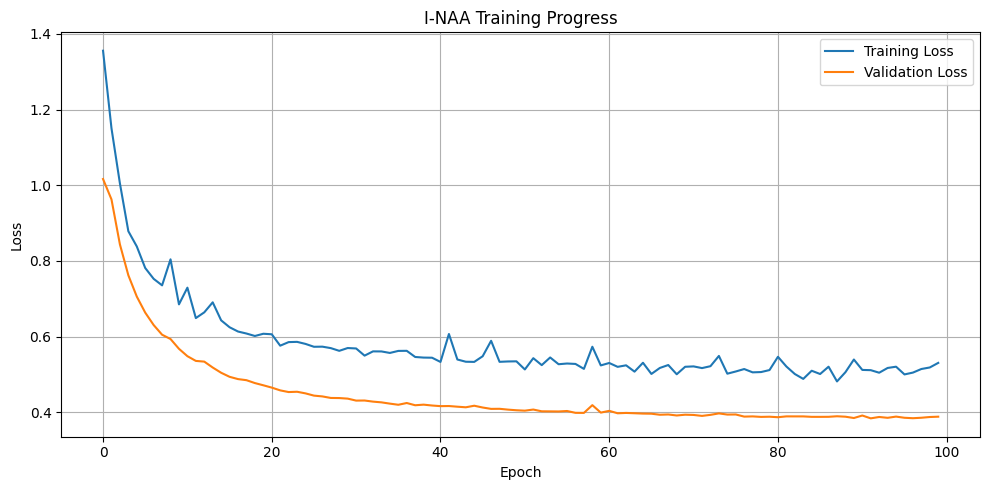

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('I-NAA Training Progress')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('inaa_training_progress.png')
plt.show()

In [21]:
print("Training complete! Model saved as './models/inaa/best_inaa_model.pt'")

Training complete! Model saved as './models/inaa/best_inaa_model.pt'


Using device: cuda
Loading the original dataset...
Total missing values: 3063 out of 78312 (3.91%)

Top 10 features with most missing values:
nucleotidase: 529 missing values (26.34%)
glutamic.oxaloacetic.transaminase: 253 missing values (12.60%)
lactate.dehydrogenase: 241 missing values (12.00%)
hydroxybutyrate.dehydrogenase: 241 missing values (12.00%)
cholesterol: 198 missing values (9.86%)
low.density.lipoprotein.cholesterol: 198 missing values (9.86%)
platelet.hematocrit: 103 missing values (5.13%)
white.globulin.ratio: 102 missing values (5.08%)
glutamic.pyruvic.transaminase: 102 missing values (5.08%)
total.protein: 102 missing values (5.08%)

Performing initial KNN imputation...

Loading the trained I-NAA model...
Model loaded successfully!

Imputing missing values with I-NAA model...

Imputed dataset saved to physionet_imputed_with_inaa.csv

Visualizing imputation results for top features with missing values...


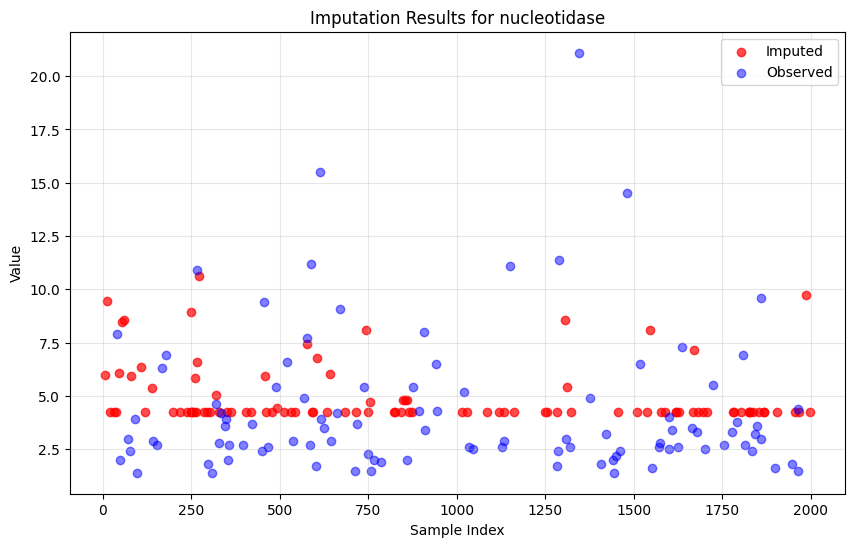

Imputation visualization for nucleotidase saved as 'imputation_results_nucleotidase.png'


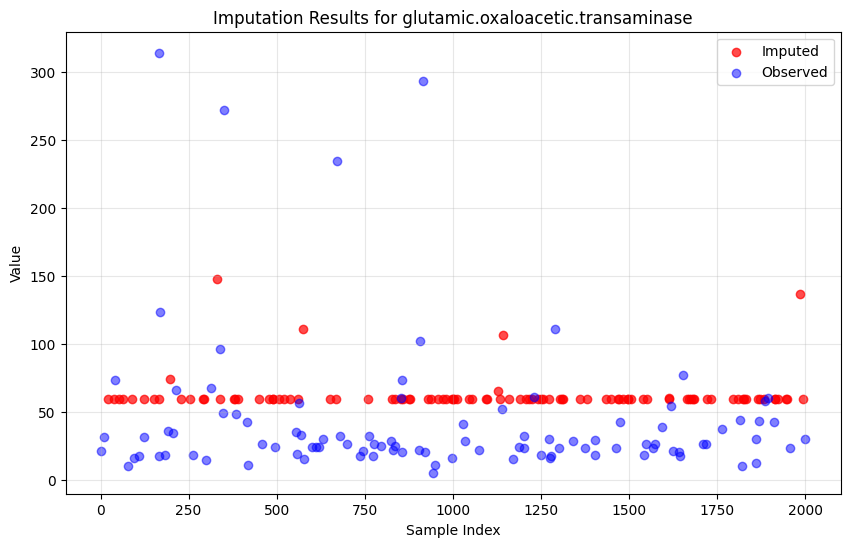

Imputation visualization for glutamic.oxaloacetic.transaminase saved as 'imputation_results_glutamic.oxaloacetic.transaminase.png'


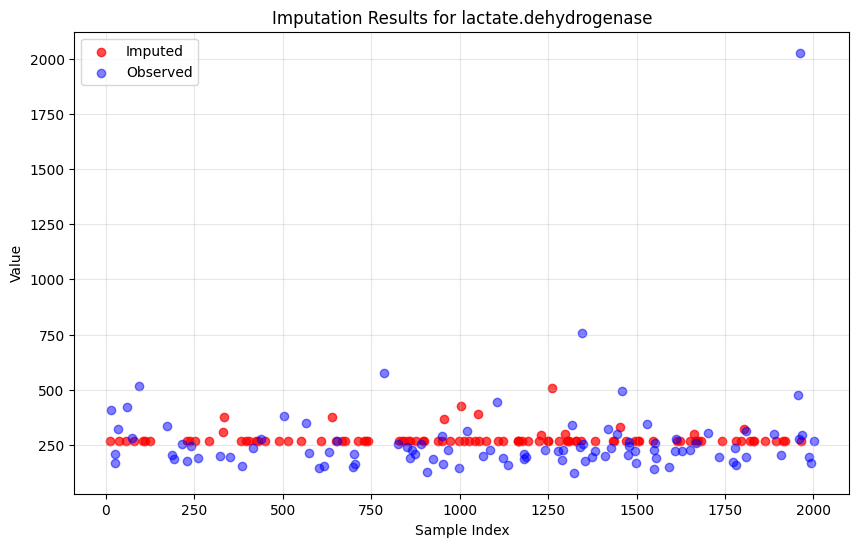

Imputation visualization for lactate.dehydrogenase saved as 'imputation_results_lactate.dehydrogenase.png'

Summary statistics before and after imputation:

Feature: nucleotidase
  Before imputation (observed values only):
    Mean: 4.2924
    Std:  3.6208
    Min:  0.3000
    Max:  31.4000
  After imputation (all values):
    Mean: 4.4736
    Std:  3.2626
    Min:  0.3000
    Max:  31.4000

Feature: glutamic.oxaloacetic.transaminase
  Before imputation (observed values only):
    Mean: 63.2202
    Std:  297.3412
    Min:  5.0000
    Max:  6640.0000
  After imputation (all values):
    Mean: 64.5431
    Std:  279.5444
    Min:  5.0000
    Max:  6640.0000

Feature: lactate.dehydrogenase
  Before imputation (observed values only):
    Mean: 273.2915
    Std:  253.1431
    Min:  107.0000
    Max:  6279.0000
  After imputation (all values):
    Mean: 274.1692
    Std:  238.2623
    Min:  107.0000
    Max:  6279.0000

Feature: hydroxybutyrate.dehydrogenase
  Before imputation (observed valu

In [23]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import torch.nn as nn

# Define the I-NAA model class (same as in training)
class ImprovedNAA(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_norm=True):
        super(ImprovedNAA, self).__init__()
        
        # Encoder
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_dim, hidden_dim))
        if batch_norm:
            encoder_layers.append(nn.BatchNorm1d(hidden_dim))
        encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder
        decoder_layers = []
        decoder_layers.append(nn.Linear(hidden_dim, input_dim))
        if batch_norm:
            decoder_layers.append(nn.BatchNorm1d(input_dim))
        decoder_layers.append(nn.ReLU())
        self.decoder = nn.Sequential(*decoder_layers)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the original dataset
print("Loading the original dataset...")
dataset_path = './data/physionet_39_features_and_target_no_leakage.csv'
df = pd.read_csv(dataset_path)

# Separate features and target
target_var = 're.admission.within.6.months'
feature_cols = [col for col in df.columns if col != target_var]
X = df[feature_cols].values
y = df[target_var].values

# Create mask for missing values (1 = observed, 0 = missing)
mask = ~np.isnan(X)

# Check missing value statistics
missing_counts = np.isnan(X).sum(axis=0)
missing_percentage = np.isnan(X).sum() / X.size
print(f"Total missing values: {np.isnan(X).sum()} out of {X.size} ({missing_percentage:.2%})")

# Check missing values by feature
missing_by_feature = pd.Series(missing_counts, index=feature_cols)
top_missing = missing_by_feature.sort_values(ascending=False).head(10)
print("\nTop 10 features with most missing values:")
for feature, count in top_missing.items():
    print(f"{feature}: {count} missing values ({count/len(df):.2%})")

# Pre-impute with KNN (same as in training)
def preprocess_with_knn(X_missing, k=5):
    """Preimpute missing values using KNN imputer."""
    imputer = KNNImputer(n_neighbors=k)
    X_imputed = imputer.fit_transform(X_missing)
    return X_imputed

# Perform KNN imputation on the original data
print("\nPerforming initial KNN imputation...")
X_knn_imputed = preprocess_with_knn(X)

# Standardize the data (fit on the KNN-imputed data)
scaler = StandardScaler()
X_knn_scaled = scaler.fit_transform(X_knn_imputed)

# Load the trained I-NAA model
print("\nLoading the trained I-NAA model...")
input_dim = X.shape[1]
hidden_dim = input_dim // 2  # Same as in training
model = ImprovedNAA(input_dim, hidden_dim).to(device)

# Load the saved model parameters
try:
    model.load_state_dict(torch.load('best_inaa_model.pt'))
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please make sure you've trained the model first.")
    exit()

# Use the model to impute missing values
print("\nImputing missing values with I-NAA model...")
model.eval()
with torch.no_grad():
    X_tensor = torch.FloatTensor(X_knn_scaled).to(device)
    X_imputed_scaled = model(X_tensor).cpu().numpy()

# Inverse transform to get back to original scale
X_imputed = scaler.inverse_transform(X_imputed_scaled)

# Create the final imputed dataset by combining:
# - Original values where they exist (mask == 1)
# - Imputed values where original had missing values (mask == 0)
X_final = X.copy()
missing_indices = np.where(~mask)
X_final[missing_indices] = X_imputed[missing_indices]

# Create the fully imputed dataframe
df_imputed = df.copy()
df_imputed[feature_cols] = X_final

# Save the imputed dataframe to a new CSV file
output_file = 'physionet_imputed_with_inaa.csv'
df_imputed.to_csv(output_file, index=False)
print(f"\nImputed dataset saved to {output_file}")

# Visualize a sample of the imputation results
def plot_imputation_sample(original, imputed, feature_name, n_samples=100):
    """Plot a sample of original vs imputed values for a specific feature"""
    plt.figure(figsize=(10, 6))
    
    # Get indices of missing values for this feature
    feature_idx = feature_cols.index(feature_name)
    missing_idx = np.where(~mask[:, feature_idx])[0]
    
    # If there are missing values for this feature
    if len(missing_idx) > 0:
        # Limit to n_samples for better visualization
        if len(missing_idx) > n_samples:
            sample_idx = np.random.choice(missing_idx, n_samples, replace=False)
        else:
            sample_idx = missing_idx
        
        # Plot imputed values
        plt.scatter(sample_idx, imputed[sample_idx, feature_idx], 
                   label='Imputed', color='red', alpha=0.7)
        
        # Plot observed values (non-missing) as reference
        observed_idx = np.where(mask[:, feature_idx])[0]
        if len(observed_idx) > n_samples:
            observed_sample = np.random.choice(observed_idx, n_samples, replace=False)
        else:
            observed_sample = observed_idx
        
        plt.scatter(observed_sample, original[observed_sample, feature_idx], 
                   label='Observed', color='blue', alpha=0.5)
        
        plt.title(f'Imputation Results for {feature_name}')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f'imputation_results_{feature_name}.png')
        plt.show()
        
        print(f"Imputation visualization for {feature_name} saved as 'imputation_results_{feature_name}.png'")
    else:
        print(f"No missing values for feature {feature_name}")

# Visualize imputation results for the top 3 features with missing values
if len(top_missing) > 0:
    print("\nVisualizing imputation results for top features with missing values...")
    for feature in top_missing.index[:min(3, len(top_missing))]:
        plot_imputation_sample(X, X_final, feature)

# Print summary statistics before and after imputation
print("\nSummary statistics before and after imputation:")
for feature in top_missing.index[:min(5, len(top_missing))]:
    # Get original and imputed values for this feature
    feature_idx = feature_cols.index(feature)
    original_values = X[:, feature_idx]
    imputed_values = X_final[:, feature_idx]
    
    # Calculate statistics for observed values
    observed_values = original_values[~np.isnan(original_values)]
    
    print(f"\nFeature: {feature}")
    print(f"  Before imputation (observed values only):")
    print(f"    Mean: {np.mean(observed_values):.4f}")
    print(f"    Std:  {np.std(observed_values):.4f}")
    print(f"    Min:  {np.min(observed_values):.4f}")
    print(f"    Max:  {np.max(observed_values):.4f}")
    
    print(f"  After imputation (all values):")
    print(f"    Mean: {np.mean(imputed_values):.4f}")
    print(f"    Std:  {np.std(imputed_values):.4f}")
    print(f"    Min:  {np.min(imputed_values):.4f}")
    print(f"    Max:  {np.max(imputed_values):.4f}")

print("\nImputation process completed successfully!")